In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q captum

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt

1.12.1+cu113
     |████████████████████████████████| 8.9 MB 2.7 MB/s 
     |████████████████████████████████| 3.5 MB 12.4 MB/s 
     |████████████████████████████████| 280 kB 4.1 MB/s 
     |████████████████████████████████| 1.4 MB 4.0 MB/s 


In [ ]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.5 MB 13.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 722 kB 3.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Loading the dataset

We load the dataset and use 10% of the data as the test split.

In [ ]:
!mkdir data

In [ ]:
!pip install dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [ ]:
import dgl

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
from torch_geometric.loader import DataLoader
import torch
from torch_geometric.data import Data
from dataset import get_amino_loader

In [ ]:
import random
dataset = get_amino_loader(split='train')
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]

test_loader = DataLoader(test_dataset, batch_size=1000)
train_loader = DataLoader(train_dataset, batch_size=64)
total_loader = DataLoader(dataset, batch_size=3000)

this is train dataset
Start train data processing....
Processing is finished!! amino train_loader init.


In [ ]:
best_dataset = dataset[0]
best = 0.020848649
for i in dataset:
  a = i.y.item()

  if best == a:
    best = a
    best_dataset = i

## Visualizing the data

We define some utility functions for visualizing the molecules and draw a random molecule.

In [ ]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False, title='molecule'):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.savefig(title+'.png', dpi=300)
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['H','C','O','N','S','P','F']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g


## Sample visualization

We sample a single molecule from train_dataset and visualize it

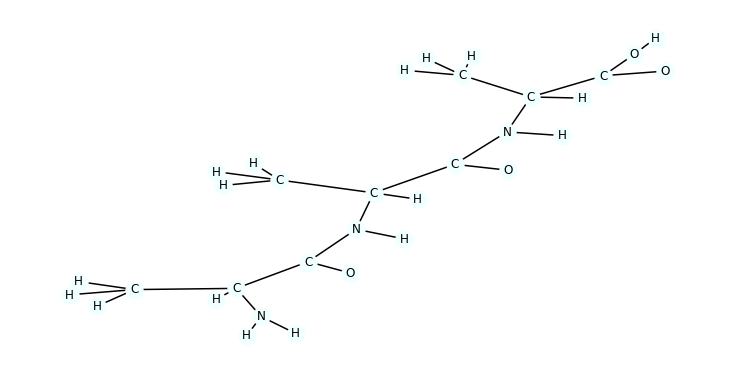

In [ ]:
import random
import matplotlib.pyplot as plt


data = best_dataset #random.choice([t for t in train_dataset])
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, title = 'best_molecular')

## Training the model

In the next section, we train a GNN model with 5 convolution layers. We use GraphConv which supports `edge_weight` as a parameter. Many convolution layers in Pytorch Geometric supoort this argument.

## HOGNN

### Define the model

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_max_pool, global_add_pool
from torch_geometric.nn.dense.dense_gcn_conv import DenseGCNConv

# 기본 gnn 모델
class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = 7 #dataset.num_features
        self.dim = dim
 
        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, 1)

    def forward(self,x,pos,z, edge_index, batch, edge_weight=None):
        
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv3(x, edge_index, edge_weight).relu()

        x = global_add_pool(x, batch)
        x = self.lin1(x)
        x = self.lin2(x)
        return x

class Feature_Net(torch.nn.Module):
    def __init__(self, dim):
        super(Feature_Net, self).__init__()

        num_features =10 #dataset.num_features
        self.dim = dim
 
        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, 1)

    def forward(self,x,pos,z, edge_index, batch, edge_weight=None):
        x = torch.cat([x,pos],dim=1).to(device, dtype=torch.float32)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv3(x, edge_index, edge_weight).relu()

        x = global_add_pool(x, batch)
        x = self.lin1(x)
        x = self.lin2(x)
        return x

### Define train and test functions

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
def train(epoch):
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x.float(),data.pos,data.z, data.edge_index, data.batch)
        loss = F.l1_loss(output.to(device), 
                         data.y.view(-1,1).to(device))
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)

def to_np(x):
    return x.cpu().detach().numpy()


def test(loader):
    model.eval()
    total_mae = 0
    for i, data in enumerate(loader):
        data = data.to(device)
        output = model(data.x,data.pos,data.z, data.edge_index, data.batch)
        mae = mean_absolute_error(to_np(output.flatten()), to_np(data.y))
        total_mae += mae
    return total_mae

def final(loader):
    model.eval()
    predict_list = []
    real_list = []
    total_mae = 0
    total_mse = 0

    for data in loader:
        data = data.to(device)
        output = model(data.x,data.pos,data.z, data.edge_index, data.batch)
        mae = mean_absolute_error(to_np(output.flatten()), to_np(data.y))
        mse = mean_squared_error(to_np(output.flatten()), to_np(data.y))
        predict_list.append(to_np(output.flatten()))
        real_list.append(to_np(data.y))
        total_mae += mae
        total_mse += mse
        
    #total_mae = total_mae/len(data)
    #total_mse = total_mse/len(data)
    return total_mae, total_mse,  predict_list, real_list


### Train the model for 100 epochs

The accuracy should be around 80% in the end

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 1.6545, Train Acc: 31.6448, Test Acc: 0.7623
Epoch: 002, Loss: 0.7916, Train Acc: 31.0217, Test Acc: 0.7412
Epoch: 003, Loss: 0.7839, Train Acc: 30.8173, Test Acc: 0.7369
Epoch: 004, Loss: 0.7828, Train Acc: 31.2225, Test Acc: 0.7540
Epoch: 005, Loss: 0.7685, Train Acc: 30.7167, Test Acc: 0.7324
Epoch: 006, Loss: 0.7655, Train Acc: 30.9733, Test Acc: 0.7412
Epoch: 007, Loss: 0.7649, Train Acc: 30.7864, Test Acc: 0.7335
Epoch: 008, Loss: 0.7646, Train Acc: 30.8674, Test Acc: 0.7366
Epoch: 009, Loss: 0.7631, Train Acc: 30.6463, Test Acc: 0.7330
Epoch: 010, Loss: 0.7579, Train Acc: 30.4389, Test Acc: 0.7312
Epoch: 011, Loss: 0.7585, Train Acc: 30.7357, Test Acc: 0.7374
Epoch: 012, Loss: 0.7603, Train Acc: 30.5288, Test Acc: 0.7282
Epoch: 013, Loss: 0.7597, Train Acc: 30.6253, Test Acc: 0.7297
Epoch: 014, Loss: 0.7549, Train Acc: 30.4228, Test Acc: 0.7249
Epoch: 015, Loss: 0.7568, Train Acc: 30.6646, Test Acc: 0.7283
Epoch: 016, Loss: 0.7544, Train Acc: 30.4495, Test Acc:

In [ ]:
final_mae, final_mse, predict_list, real_list = final(total_loader)

In [ ]:
final_mae 

0.7051023244857788

In [ ]:
final_mse

0.8466269969940186

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Feature_Net(dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 6.9903, Train Acc: 82.7062, Test Acc: 1.6556
Epoch: 002, Loss: 1.2897, Train Acc: 38.0650, Test Acc: 0.8835
Epoch: 003, Loss: 0.9017, Train Acc: 32.7137, Test Acc: 0.7133
Epoch: 004, Loss: 0.8454, Train Acc: 33.6136, Test Acc: 0.8539
Epoch: 005, Loss: 0.8459, Train Acc: 32.6901, Test Acc: 0.7914
Epoch: 006, Loss: 0.8160, Train Acc: 32.4340, Test Acc: 0.7837
Epoch: 007, Loss: 0.7945, Train Acc: 31.6919, Test Acc: 0.7679
Epoch: 008, Loss: 0.7959, Train Acc: 31.7225, Test Acc: 0.7811
Epoch: 009, Loss: 0.7842, Train Acc: 31.4458, Test Acc: 0.7525
Epoch: 010, Loss: 0.7666, Train Acc: 31.6273, Test Acc: 0.7842
Epoch: 011, Loss: 0.7746, Train Acc: 31.2249, Test Acc: 0.7836
Epoch: 012, Loss: 0.7887, Train Acc: 31.0797, Test Acc: 0.7739
Epoch: 013, Loss: 0.8108, Train Acc: 32.1641, Test Acc: 0.7377
Epoch: 014, Loss: 0.7922, Train Acc: 31.4295, Test Acc: 0.7572
Epoch: 015, Loss: 0.8076, Train Acc: 31.2693, Test Acc: 0.7456
Epoch: 016, Loss: 0.7853, Train Acc: 31.6352, Test Acc:

In [ ]:
final_mae,final_mse, predict_list, real_list = final(test_loader)

In [ ]:
final_mae 

0.7413583993911743

In [ ]:
final_mse

0.9343597888946533

## GCN

### Define the model

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from torch_geometric.nn import GraphConv, global_add_pool

class GCN(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        num_features = 7 #dataset.num_features
        self.conv1 = GCNConv(num_features, dim)
        self.conv2 = GCNConv(dim, dim)
        self.conv3 = GCNConv(dim, dim)
        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, 1)

    def forward(self,x,pos,z, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv3(x, edge_index, edge_weight).relu()

        x = global_add_pool(x, batch)
        x = self.lin1(x)
        x = self.lin2(x)

        return x

class Feature_GCN(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        num_features = 11 #dataset.num_features
        self.conv1 = GCNConv(num_features, dim)
        self.conv2 = GCNConv(dim, dim)
        self.conv3 = GCNConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, 1)

    def forward(self,x,pos,z, edge_index, batch, edge_weight=None):
        x = torch.cat([x,pos,z.view(-1,1)],dim=1).float()
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv3(x, edge_index, edge_weight).relu()

        x = global_add_pool(x, batch)
        x = self.lin1(x)
        x = self.lin2(x)
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

In [ ]:
final_mae,final_mse, predict_list, real_list = final(test_loader)

In [ ]:
final_mae

0.702551543712616

In [ ]:
final_mse

0.851981520652771

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Feature_GCN(dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 1.3053, Train Acc: 32.4516, Test Acc: 0.7836
Epoch: 002, Loss: 0.7978, Train Acc: 31.4992, Test Acc: 0.7576
Epoch: 003, Loss: 0.8157, Train Acc: 32.2906, Test Acc: 0.7361
Epoch: 004, Loss: 0.7978, Train Acc: 33.5876, Test Acc: 0.7545
Epoch: 005, Loss: 0.8003, Train Acc: 32.1851, Test Acc: 0.7718
Epoch: 006, Loss: 0.7991, Train Acc: 31.6553, Test Acc: 0.7459
Epoch: 007, Loss: 0.7829, Train Acc: 31.5013, Test Acc: 0.7503
Epoch: 008, Loss: 0.7776, Train Acc: 31.2476, Test Acc: 0.7481
Epoch: 009, Loss: 0.7717, Train Acc: 31.2031, Test Acc: 0.7489
Epoch: 010, Loss: 0.7687, Train Acc: 31.1437, Test Acc: 0.7474
Epoch: 011, Loss: 0.7666, Train Acc: 31.2282, Test Acc: 0.7495
Epoch: 012, Loss: 0.7680, Train Acc: 31.1831, Test Acc: 0.7491
Epoch: 013, Loss: 0.7667, Train Acc: 31.0977, Test Acc: 0.7487
Epoch: 014, Loss: 0.7679, Train Acc: 31.1191, Test Acc: 0.7497
Epoch: 015, Loss: 0.7645, Train Acc: 31.0500, Test Acc: 0.7505
Epoch: 016, Loss: 0.7651, Train Acc: 31.0348, Test Acc:

In [ ]:
final_mae,final_mse, predict_list, real_list = final(test_loader)

In [ ]:
final_mae

0.7494462132453918

In [ ]:
final_mse

0.9429948925971985

# sage

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv

from torch_geometric.nn import GraphConv, global_add_pool

# 기본 gnn 모델
class SAGE(torch.nn.Module):
    def __init__(self, dim):
        super(SAGE, self).__init__()

        num_features = 7 #dataset.num_features
        self.dim = dim
 
        self.conv1 = SAGEConv(num_features, dim)
        self.conv2 = SAGEConv(dim, dim)
        self.conv3 = SAGEConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, 1)

    def forward(self,x,pos,z, edge_index, batch, edge_weight=None):
        
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv3(x, edge_index, edge_weight).relu()

        x = global_add_pool(x, batch)
        x = self.lin1(x)
        x = self.lin2(x)
        return x

class Feature_SAGE(torch.nn.Module):
    def __init__(self, dim):
        super(Feature_SAGE, self).__init__()

        num_features =11 #dataset.num_features
        self.dim = dim
 
        self.conv1 = SAGEConv(num_features, dim)
        self.conv2 = SAGEConv(dim, dim)
        self.conv3 = SAGEConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, 1)

    def forward(self,x,pos,z, edge_index, batch, edge_weight=None):
        x = torch.cat([x,pos,z.view(-1,1)],dim=1).to(device, dtype=torch.float32)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv3(x, edge_index, edge_weight).relu()

        x = global_add_pool(x, batch)
        x = self.lin1(x)
        x = self.lin2(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

In [ ]:
final_mae,final_mse, predict_list, real_list = final(final_loader)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Feature_SAGE(dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 131.3907, Train Acc: 83.6526, Test Acc: 113.8196
Epoch: 002, Loss: 78.7655, Train Acc: 78.7566, Test Acc: 100.7651
Epoch: 003, Loss: 75.2702, Train Acc: 77.0857, Test Acc: 101.8770
Epoch: 004, Loss: 75.9317, Train Acc: 76.8022, Test Acc: 100.9016
Epoch: 005, Loss: 75.5582, Train Acc: 75.2708, Test Acc: 99.2577
Epoch: 006, Loss: 76.0433, Train Acc: 76.4832, Test Acc: 98.9521
Epoch: 007, Loss: 73.1173, Train Acc: 73.3459, Test Acc: 96.2229
Epoch: 008, Loss: 73.7523, Train Acc: 73.9876, Test Acc: 96.3750
Epoch: 009, Loss: 71.6176, Train Acc: 73.2905, Test Acc: 95.9189
Epoch: 010, Loss: 73.0925, Train Acc: 72.4943, Test Acc: 93.5661
Epoch: 011, Loss: 73.5552, Train Acc: 73.4034, Test Acc: 94.7318
Epoch: 012, Loss: 71.4746, Train Acc: 75.2635, Test Acc: 97.5915
Epoch: 013, Loss: 71.9002, Train Acc: 73.3989, Test Acc: 94.7311
Epoch: 014, Loss: 70.0001, Train Acc: 72.1846, Test Acc: 93.1269
Epoch: 015, Loss: 69.7131, Train Acc: 73.2598, Test Acc: 95.3085
Epoch: 016, Loss: 69

In [ ]:
final_mae,final_mse, predict_list, real_list = final(final_loader)

# GAT

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self,dim):
        super(GAT,self).__init__()
        
        num_features = 7 #dataset.num_features

        self.conv1 = GATConv(num_features, dim)
        self.conv2 = GATConv(dim, dim)
        self.conv3 = GATConv(dim, dim)
 
        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, 1)

    def forward(self,x,pos,z, edge_index, batch, edge_weight=None):
        #x = torch.cat([x,pos,z.view(-1,1)],dim=1).float()
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin2(x)
        return x

class Feature_GAT(torch.nn.Module):
    def __init__(self,dim):
        super(Feature_GAT,self).__init__()
        
        num_features = 11 #dataset.num_features

        self.conv1 = GATConv(num_features, dim)
        self.conv2 = GATConv(dim, dim)
        self.conv3 = GATConv(dim, dim)
 
        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, 1)

    def forward(self,x,pos,z, edge_index, batch, edge_weight=None):
        x = torch.cat([x,pos,z.view(-1,1)],dim=1).float()
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin2(x)
        return x



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

In [ ]:
final_mae, final_mse, predict_list, real_list = final(final_loader)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Feature_GAT(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 344.9339, Train Acc: 249.1618, Test Acc: 296.5520
Epoch: 002, Loss: 128.3351, Train Acc: 100.9013, Test Acc: 124.4434
Epoch: 003, Loss: 93.6071, Train Acc: 86.8188, Test Acc: 116.4559
Epoch: 004, Loss: 89.9244, Train Acc: 84.0965, Test Acc: 116.1204
Epoch: 005, Loss: 89.5753, Train Acc: 82.9402, Test Acc: 115.7570
Epoch: 006, Loss: 87.3989, Train Acc: 83.2990, Test Acc: 116.2126
Epoch: 007, Loss: 88.4125, Train Acc: 81.2700, Test Acc: 113.6698
Epoch: 008, Loss: 86.6338, Train Acc: 80.3568, Test Acc: 111.8259
Epoch: 009, Loss: 84.5513, Train Acc: 80.3851, Test Acc: 110.9921
Epoch: 010, Loss: 85.5862, Train Acc: 80.7454, Test Acc: 112.8962
Epoch: 011, Loss: 84.1905, Train Acc: 79.8879, Test Acc: 112.5469
Epoch: 012, Loss: 82.0355, Train Acc: 79.9545, Test Acc: 112.1364
Epoch: 013, Loss: 81.1158, Train Acc: 78.9150, Test Acc: 110.6009
Epoch: 014, Loss: 79.9915, Train Acc: 79.6160, Test Acc: 111.2218
Epoch: 015, Loss: 80.3213, Train Acc: 79.0598, Test Acc: 109.7210
Epoch:

In [ ]:
final_mae, final_mse, predict_list, real_list = final(final_loader)

# DimeNet

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_max_pool

from sklearn.metrics import mean_absolute_error

def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.z,data.pos.float(),data.batch)
        loss = F.l1_loss(output.flatten().to(device), 
                         data.y.type(torch.LongTensor).to(device))
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)

def to_np(x):
    return x.cpu().detach().numpy()


def test(loader):
    model.eval()
    total_mae = 0
    for i, data in enumerate(loader):
        data = data.to(device)
        output = model(data.z, data.pos.float(), data.batch)
        mae = mean_absolute_error(to_np(output.flatten()), to_np(data.y.type(torch.LongTensor)))
        total_mae += mae
    return total_mae / i+1

def final(model,loader):
    model.eval()
    predict_list = []
    real_list = []
    total_mae = 0
    total_mse = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
          output = model(data.z, data.pos.float(), data.batch)
        mae = mean_absolute_error(to_np(output.flatten()), to_np(data.y.type(torch.LongTensor)))
        mse = mean_squared_error(to_np(output.flatten()), to_np(data.y.type(torch.LongTensor)))
        predict_list.append(to_np(output.flatten()))
        real_list.append(to_np(data.y.type(torch.LongTensor)))
        total_mae += mae
        total_mse += mse
    return total_mae,total_mse, predict_list, real_list

In [ ]:
# DimeNet
from torch_geometric.nn import DimeNet, DimeNetPlusPlus

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DimeNet(hidden_channels=128,
                out_channels=1,
                num_blocks=6,
                num_bilinear=8,
                num_spherical=7,
                num_radial=6,
                max_num_neighbors=4
                ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 620.3647, Train Acc: 86.5792, Test Acc: 117.7467
Epoch: 002, Loss: 80.8010, Train Acc: 77.9716, Test Acc: 104.0592
Epoch: 003, Loss: 75.2450, Train Acc: 73.2483, Test Acc: 95.7713
Epoch: 004, Loss: 72.0943, Train Acc: 72.1806, Test Acc: 93.7649
Epoch: 005, Loss: 71.0568, Train Acc: 71.6722, Test Acc: 92.3990
Epoch: 006, Loss: 70.5231, Train Acc: 70.9729, Test Acc: 91.1117
Epoch: 007, Loss: 69.4592, Train Acc: 72.9684, Test Acc: 92.8657
Epoch: 008, Loss: 70.1427, Train Acc: 69.9489, Test Acc: 89.7148
Epoch: 009, Loss: 67.7105, Train Acc: 70.7448, Test Acc: 90.2182
Epoch: 010, Loss: 67.7619, Train Acc: 68.9585, Test Acc: 88.1220
Epoch: 011, Loss: 67.3938, Train Acc: 67.6224, Test Acc: 86.7072
Epoch: 012, Loss: 66.5471, Train Acc: 66.7605, Test Acc: 85.7842
Epoch: 013, Loss: 65.0921, Train Acc: 67.0427, Test Acc: 86.2518
Epoch: 014, Loss: 64.7361, Train Acc: 66.3341, Test Acc: 86.0447
Epoch: 015, Loss: 63.6948, Train Acc: 66.2245, Test Acc: 86.6989
Epoch: 016, Loss: 64.3

In [ ]:
final_mae,final_mse, predict_list, real_list = final(model,final_loader)

# Explaining the predictions

In [ ]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x,data.pos,data.z, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=data.y):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

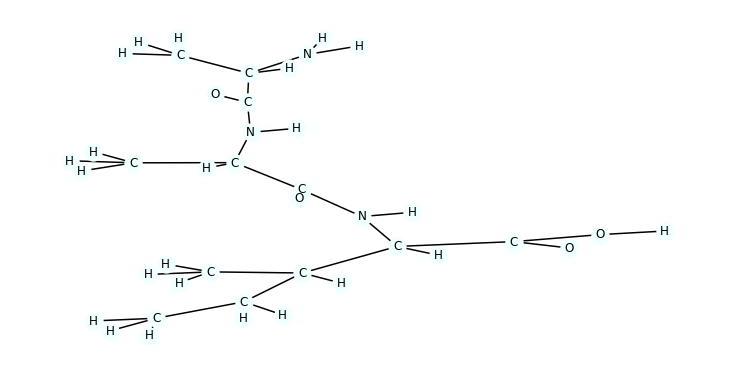

In [ ]:
import random
import matplotlib.pyplot as plt

# 0 4 7
data = test_dataset[7] #random.choice([t for t in train_dataset])
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol,title='mol7')

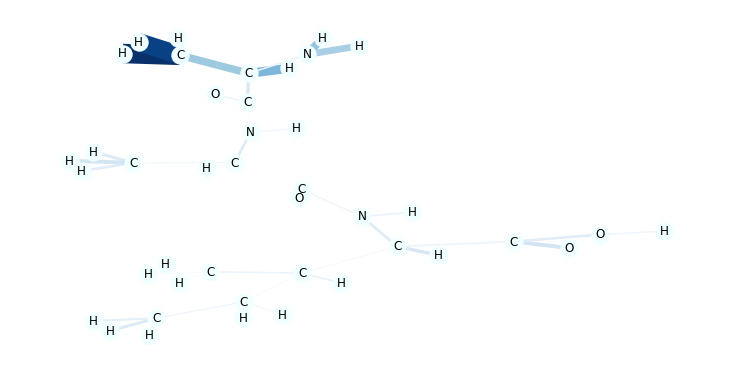

In [ ]:
import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict
    
# 0 4 7
data = test_dataset[7] # random.choice([t for t in test_dataset])
mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    #plt.title(title)
    draw_molecule(mol, edge_mask_dict, title='GCN7')